In [1]:
import os 
import numpy as np 
import pandas as pd 
import tqdm as tqdm
import cv2
import matplotlib.pyplot as plt #plotting figures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras import optimizers

Using TensorFlow backend.


In [2]:
INDOOR_DIR = "300W/01_Indoor/"
INDOOR_FILE = "indoor_"
POINTS = ".pts"
IMAGE = ".png"

In [3]:
def load(path, Rx, Ry):

    with open(path) as f:
        rows = [rows.strip() for rows in f]
    
    head = rows.index('{') + 1
    tail = rows.index('}')

    raw_points = rows[head:tail]
    points = []
    for row in raw_points:
        row = row.split(" ")
        x = float(row[0]) * Rx
        y = float(row[1]) * Ry
        points.append(x)
        points.append(y)
    data = np.array(points)
    return points

def imagenumber(number):
    if number/1000 >= .1:
        return str(number)
    elif number/100 >= .1:
        return "0" + str(number)
    else:
        return "00" + str(number)

def getData(DIR,FILE):
    images = []
    points = []
    for index in tqdm.tqdm(range(1,301)):
        index_string = imagenumber(index)
        Image_DIR = DIR + FILE +index_string+ IMAGE
        Points_DIR = DIR + FILE +index_string+ POINTS
        img = cv2.imread(Image_DIR)
        height, width , rgb  = img.shape
        resized_image = cv2.resize(img, (96, 96))
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        Rx = 96/width
        Ry = 96/height
        points.append(load(Points_DIR, Rx, Ry))
        images.append(gray_image)
    return np.array(images), np.array(points)

In [4]:
images, points = getData(INDOOR_DIR,INDOOR_FILE)

100%|██████████| 300/300 [00:23<00:00, 12.66it/s]


In [5]:
points.shape

(300, 136)

In [6]:
image1_keyvalues = points[100].reshape(68,2)
imagetest = images[100]

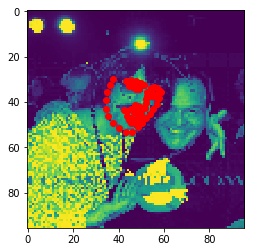

In [7]:
plt.plot(image1_keyvalues[:, 0], image1_keyvalues[:, 1], 'ro')
plt.imshow(imagetest)

In [8]:
X = images/255

In [9]:
X_train = X.reshape(X.shape[0],96,96,1)
print(X_train.shape)

(300, 96, 96, 1)


In [10]:
points.shape

(300, 136)

In [11]:
output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y_train = output_pipe.fit_transform(points)

In [12]:
print (y_train.shape)

(300, 136)


In [14]:
model = Sequential()
# input layer
model.add(BatchNormalization(input_shape=(96, 96,1)))
model.add(Conv2D(12, (2,2), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.1))
# layer 2
model.add(Conv2D(24, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))


# layer 3
model.add(Conv2D(48, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))


# layer 4
model.add(Conv2D(96, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.4))


# layer 5
model.add(Conv2D(192, (2, 2)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Flatten())

# layer 8
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
# layer 9
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(4096, activation="relu"))

# layer 10
model.add(Dense(136))

In [ ]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
epochs = 200
history = model.fit(X_train, y_train, validation_split=0.3, shuffle=True, epochs=epochs, batch_size=30)

Train on 210 samples, validate on 90 samples
Epoch 1/200
210/210 [==============================] - 6s 30ms/step - loss: 0.5534 - acc: 0.0286 - val_loss: 0.1483 - val_acc: 0.0000e+00
Epoch 2/200
210/210 [==============================] - 4s 18ms/step - loss: 0.1741 - acc: 0.0048 - val_loss: 0.1441 - val_acc: 0.0333
Epoch 3/200
210/210 [==============================] - 4s 18ms/step - loss: 0.1624 - acc: 0.0238 - val_loss: 0.1313 - val_acc: 0.0000e+00
Epoch 4/200
210/210 [==============================] - 4s 18ms/step - loss: 0.1556 - acc: 0.0333 - val_loss: 0.1352 - val_acc: 0.0111
Epoch 5/200
210/210 [==============================] - 4s 18ms/step - loss: 0.1570 - acc: 0.0762 - val_loss: 0.1296 - val_acc: 0.0889
Epoch 6/200
210/210 [==============================] - 4s 18ms/step - loss: 0.1573 - acc: 0.1190 - val_loss: 0.1307 - val_acc: 0.0556
Epoch 7/200
210/210 [==============================] - 4s 19ms/step - loss: 0.1558 - acc: 0.0381 - val_loss: 0.1293 - val_acc: 0.0111
Epoch 8/2

210/210 [==============================] - 3s 15ms/step - loss: 0.1343 - acc: 0.0905 - val_loss: 0.1244 - val_acc: 0.1000
Epoch 62/200
210/210 [==============================] - 4s 17ms/step - loss: 0.1372 - acc: 0.1190 - val_loss: 0.1271 - val_acc: 0.1111
Epoch 63/200
210/210 [==============================] - 4s 17ms/step - loss: 0.1379 - acc: 0.1000 - val_loss: 0.1212 - val_acc: 0.0667
Epoch 64/200
210/210 [==============================] - 4s 19ms/step - loss: 0.1346 - acc: 0.1286 - val_loss: 0.1271 - val_acc: 0.1000
Epoch 65/200
210/210 [==============================] - 4s 18ms/step - loss: 0.1383 - acc: 0.0571 - val_loss: 0.1288 - val_acc: 0.0333
Epoch 66/200
210/210 [==============================] - 4s 20ms/step - loss: 0.1440 - acc: 0.0667 - val_loss: 0.1201 - val_acc: 0.1000
Epoch 67/200
210/210 [==============================] - 4s 21ms/step - loss: 0.1382 - acc: 0.1048 - val_loss: 0.1231 - val_acc: 0.0556
Epoch 68/200
210/210 [==============================] - 4s 19ms/step

210/210 [==============================] - 4s 17ms/step - loss: 0.1133 - acc: 0.1238 - val_loss: 0.1229 - val_acc: 0.0778
Epoch 122/200
210/210 [==============================] - 3s 16ms/step - loss: 0.1125 - acc: 0.1381 - val_loss: 0.1323 - val_acc: 0.1556
Epoch 123/200
210/210 [==============================] - 4s 18ms/step - loss: 0.1086 - acc: 0.1524 - val_loss: 0.1241 - val_acc: 0.1556
Epoch 124/200
210/210 [==============================] - 4s 17ms/step - loss: 0.1113 - acc: 0.0905 - val_loss: 0.1284 - val_acc: 0.1667
Epoch 125/200
210/210 [==============================] - 3s 16ms/step - loss: 0.1092 - acc: 0.1476 - val_loss: 0.1258 - val_acc: 0.1444
Epoch 126/200
210/210 [==============================] - 4s 18ms/step - loss: 0.1035 - acc: 0.1048 - val_loss: 0.1201 - val_acc: 0.0778
Epoch 127/200
210/210 [==============================] - 5s 23ms/step - loss: 0.1016 - acc: 0.1190 - val_loss: 0.1259 - val_acc: 0.1111
Epoch 128/200
210/210 [==============================] - 5s 25

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("FacialKeyPoints.h5")

[[42.681225 43.255333]
 [42.796543 45.736736]
 [42.91112  46.87182 ]
 [43.23889  48.082764]
 [43.674797 49.13143 ]
 [44.08372  53.192562]
 [44.479355 55.804802]
 [44.932953 56.256485]
 [45.687447 56.11503 ]
 [46.677937 55.90216 ]
 [47.969604 53.871803]
 [49.519516 52.120556]
 [51.372334 49.340958]
 [52.124477 48.161556]
 [52.569958 47.144733]
 [52.935204 46.126072]
 [52.78007  45.107647]
 [42.372246 41.40988 ]
 [42.529877 40.40765 ]
 [42.814423 40.261456]
 [43.154568 40.6975  ]
 [43.425304 41.799824]
 [44.958252 43.386845]
 [47.108974 40.993813]
 [49.504852 41.00186 ]
 [51.07247  41.737286]
 [51.644375 43.55432 ]
 [44.03006  44.457005]
 [43.980797 45.065533]
 [43.91137  45.688328]
 [43.885914 46.341354]
 [43.625057 47.221336]
 [43.93886  47.261303]
 [44.37053  47.321823]
 [44.81229  47.255047]
 [45.406906 47.145466]
 [42.77051  45.115826]
 [42.876507 44.790947]
 [43.228397 44.809757]
 [43.5727   45.174603]
 [43.34123  45.305523]
 [42.987896 45.280563]
 [45.323994 45.12615 ]
 [47.11306 

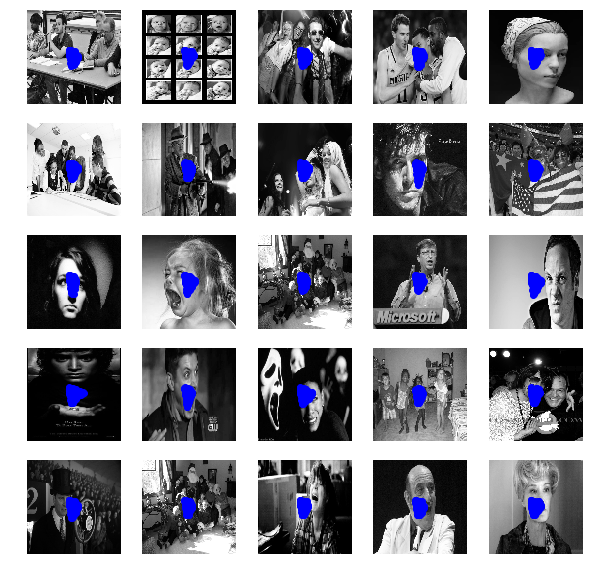

In [31]:
def plot_faces_with_keypoints_and_predictions(model, nrows=5, ncols=5, model_input='flat'):
    """Plots sampled faces with their truth and predictions."""
    selection = np.random.choice(np.arange(images.shape[0]), size=(nrows*ncols), replace=False)
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X_train[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model.predict(img.reshape(1, -1))
        else:
            predictions = model.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(68, 2)
        ax.imshow(img, cmap='gray')
        ax.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'bo')
        ax.axis('off')
    print(xy_predictions)
plot_faces_with_keypoints_and_predictions(model, model_input='2d')

In [21]:
#5-layerleNet

model2 = Sequential()
# input layer
model2.add(BatchNormalization(input_shape=(96, 96,1)))
model2.add(Conv2D(16, (3, 3), kernel_initializer='he_normal'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# layer 2
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# layer 3
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# layer 4
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# layer 5
model2.add(Conv2D(256, (3, 3)))
model2.add(Activation('relu'))
model2.add(Flatten())
# layer 6
model2.add(Dense(500, activation="relu"))
# layer 7
model2.add(Dense(500, activation="relu"))
# layer 8
model2.add(Dense(500, activation="relu"))
# layer 9
model2.add(Dense(500, activation="relu"))
# layer 10
model.add(Dense(136,  activation="softmax"))

In [22]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 200
history = model2.fit(X_train, y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

ValueError: Error when checking target: expected dense_7 to have shape (500,) but got array with shape (136,)